# Metrics: Evaluating Model Performance
This notebook covers how to select and evaluate machine learning models using metrics in scikit-learn. Using a real-world credit card fraud detection dataset, you will learn how to compare models and use GridSearchCV for systematic evaluation.

In [1]:
# Import libraries for data handling, numerical operations, and plotting
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

# The dataset is large, so we only read the first 80,000 rows for faster processing
df = pd.read_csv("creditcard.csv")[:80_000]
df.head(3)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


The dataset contains many columns, most of which are anonymized for privacy. At the end of the DataFrame, you'll find the `Class` column (our prediction target, indicating fraud or not) and the `Amount` column (the transaction amount).

The anonymized features are labeled `V1` through `V28`, each representing characteristics of a transaction. Our goal is to use these features to predict whether a transaction is fraudulent.

To use this data with scikit-learn, we need to separate the features (input variables) from the target (output label). We'll convert the relevant columns to NumPy arrays for compatibility with scikit-learn's API.

In [ ]:
# X contains all columns with a 'V' in the name (features), y is the column we want to predict (fraud or not)
X = df.drop(columns=["Time", "Amount", "Class"]).values
y = df["Class"].values


To better understand the dataset, let's print the shape of our feature and label arrays, as well as the number of fraud cases. This helps us see how many samples we have and highlights the class imbalance—a common challenge in fraud detection.

In [3]:
# Print the shapes of X and y, and the number of fraud cases in the dataset
f"Shapes of X={X.shape} y={y.shape}, #Fraud Cases={y.sum()}"


'Shapes of X=(80000, 28) y=(80000,), #Fraud Cases=196'

Notice that the number of fraud cases is very small compared to the total number of transactions—only about 200 out of 80,000. This means the dataset is highly *imbalanced*, with far more non-fraud cases than fraud cases.

Class imbalance is important to consider because many models can achieve high accuracy simply by predicting the majority class (non-fraud). However, our goal is to detect as many fraud cases as possible.

Let's start by training a simple logistic regression model to see how it performs on this imbalanced data.

In [ ]:
# Import LogisticRegression for classification
from sklearn.linear_model import LogisticRegression

# mod = LogisticRegression()
# mod.fit(X, y).predict(X)


When fitting the logistic regression model, you may encounter a warning that the maximum number of iterations has been reached. This often happens with imbalanced datasets, as the model struggles to converge within the default number of iterations.

To address this, we increase the `max_iter` parameter. After fitting the model, we can check how many fraud cases the model predicts. This gives us an initial sense of model performance, even before using more formal metrics.

In [5]:
# Increase max_iter to help the model converge on imbalanced data
mod = LogisticRegression(max_iter=1_000)
mod.fit(X, y).predict(X).sum()


151

This initial approach is a simple baseline, but it may not detect enough fraud cases due to the class imbalance. One way to address this is by adjusting the `class_weight` parameter in logistic regression.

The `class_weight` parameter lets us assign more importance to the minority class (fraud). For example, we can double the weight for fraud cases (`class 1`) compared to non-fraud cases (`class 0`). This encourages the model to pay more attention to fraud detection, potentially increasing the number of fraud cases it identifies.

Let's see how changing the class weights affects the model's predictions.

In [6]:
# Set class_weight to give more importance to fraud cases and see how predictions change
mod = LogisticRegression(class_weight={0: 1, 1: 2}, max_iter=1_000)
mod.fit(X, y).predict(X).sum()


171

By increasing the weight for fraud cases, the model is able to detect more of them. This demonstrates how hyperparameters like `class_weight` can significantly impact model performance.

To systematically find the best settings, we can use a grid search. Grid search tests multiple hyperparameter values (such as different class weights) and evaluates each model using a chosen metric. This helps us identify the configuration that works best for our specific problem.

Let's set up a grid search to optimize the class weight parameter.

In [7]:
# Import GridSearchCV to search for the best hyperparameters automatically
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1_000),
    # Test different weights for the fraud class
    param_grid={"class_weight": [{0: 1, 1: v} for v in range(1, 4)]},
    cv=4,
    n_jobs=-1,
)

grid.fit(X, y)


GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}]})

After running the grid search, we can access the cross-validation results through the `cv_results_` attribute. This contains detailed information about each parameter combination tested, including the scores for each fold.

By converting `cv_results_` to a DataFrame, we can easily inspect and analyze the results.

In [8]:
# Convert the grid search results to a DataFrame for easier inspection
# grid.cv_results_
pd.DataFrame(grid.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.463532,0.061621,0.002343,0.001089,"{0: 1, 1: 1}","{'class_weight': {0: 1, 1: 1}}",0.99405,0.99835,0.99945,0.99780,0.997413,0.002030,1
1,0.431063,0.059859,0.001593,0.000122,"{0: 1, 1: 2}","{'class_weight': {0: 1, 1: 2}}",0.99020,0.99840,0.99960,0.99805,0.996563,0.003718,2
2,0.393593,0.048405,0.001332,0.000284,"{0: 1, 1: 3}","{'class_weight': {0: 1, 1: 3}}",0.98730,0.99845,0.99960,0.99815,0.995875,0.004980,3


In the results, you'll see the tested class weights (`param_class_weight`) and the corresponding scores for each cross-validation split. By default, grid search uses the model's `score` method to evaluate performance.

For logistic regression, the default `score` method computes **accuracy**—the proportion of correct predictions. However, in imbalanced datasets, accuracy can be misleading: a model that always predicts "not fraud" will have high accuracy but fail to detect fraud cases.

Let's check which metric is being used by default and discuss why accuracy may not be the best choice for this problem.

In [9]:
# Create a LogisticRegression object and check its default scoring method
lr = LogisticRegression()
lr.score


<bound method ClassifierMixin.score of LogisticRegression()>

In [10]:
# Use ?? to display the source code or documentation for the score method
??lr.score


Signature: lr.score(X, y, sample_weight=None)
Source:   
    def score(self, X, y, sample_weight=None):
        """
        Return the mean accuracy on the given test data and labels.

        In multi-label classification, this is the subset accuracy
        which is a harsh metric since you require for each sample that
        each label set be correctly predicted.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test samples.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            True labels for X.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.

        Returns
        -------
        score : float
            Mean accuracy of self.predict(X) wrt. y.
        """
        from .metrics import accuracy_score
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
File:      ~/dev/github-ryouze/scikit-learn-practice/env/lib/py

The `score` method in logistic regression returns the **accuracy** of the model, which is the fraction of correct predictions out of all predictions. Internally, it uses `accuracy_score` from scikit-learn's metrics module.

While accuracy is a common metric, it is not always appropriate for imbalanced datasets. In our case, predicting all transactions as non-fraud would yield high accuracy, but the model would miss nearly all fraud cases.

To better evaluate model performance in this context, we should consider other metrics such as **precision** and **recall**.

## What is Accuracy?

**Accuracy** is the most basic metric for classification. It measures the proportion of correct predictions out of all predictions made.

**Formula:**

    Accuracy = (Number of Correct Predictions) / (Total Number of Predictions)

**Example:**
Suppose you have 100 transactions, and only 2 are fraud. If your model predicts "not fraud" for every transaction, it will be correct 98 times and wrong 2 times. So, the accuracy is 98%.

**Why is this misleading?**
In imbalanced datasets (like fraud detection), accuracy can be very high even if the model never detects any fraud! That's why we need other metrics to evaluate performance more meaningfully.

In [ ]:
# Import precision_score and recall_score to measure model performance on imbalanced data
from sklearn.metrics import precision_score, recall_score


Scikit-learn provides many metrics for classification problems. Two important ones for imbalanced datasets are **precision** and **recall**:

- **Precision** measures the proportion of predicted fraud cases that are actually fraud. High precision means that when the model predicts fraud, it is usually correct.
- **Recall** measures the proportion of actual fraud cases that the model successfully detects. High recall means the model catches most fraud cases.

Let's compute precision and recall for our model using the true labels and the model's predictions.

## What is Recall?

**Recall** (also called Sensitivity or True Positive Rate) measures how many of the actual positive cases (e.g., frauds) your model successfully finds.

**Formula:**

    Recall = (Number of True Positives) / (Number of Actual Positives)

**Example:**
If there are 100 fraud cases and your model finds 80 of them, recall is 80/100 = 0.8 (or 80%).

**Why is recall important?**
In fraud detection, missing a fraud (false negative) can be very costly. High recall means you catch most of the frauds, even if you sometimes make mistakes (false alarms).

In [12]:
# Calculate the precision score: how many predicted frauds are actually fraud?
precision_score(y, grid.predict(X))


0.7682119205298014

Precision and recall capture different aspects of model performance:

- **Recall** answers: "Of all actual fraud cases, how many did the model find?"
- **Precision** answers: "Of all cases the model predicted as fraud, how many were truly fraud?"

There is often a trade-off between the two. For example, predicting every transaction as fraud gives perfect recall but poor precision. Conversely, being very selective may yield high precision but low recall.

Depending on the application, you may care more about one metric than the other. In fraud detection, missing fraud (low recall) can be costly, but too many false alarms (low precision) can also be problematic.

## What is F1 Score?

**F1 Score** is a metric that combines both precision and recall into a single number. It is the harmonic mean of precision and recall, and is especially useful when you want a balance between the two.

**Formula:**

    F1 = 2 * (Precision * Recall) / (Precision + Recall)

**Example:**
If your model has precision = 0.6 and recall = 0.8:

    F1 = 2 * (0.6 * 0.8) / (0.6 + 0.8) = 0.685

**Why use F1 score?**
F1 score is helpful when you care about both catching as many positives as possible (recall) and making sure your positive predictions are correct (precision). It is especially useful for imbalanced datasets, where accuracy alone can be misleading.

In [13]:
# Calculate the recall score: how many actual frauds did the model find?
recall_score(y, grid.predict(X))


0.5918367346938775

To compare models using different metrics, we can add precision and recall as scoring functions in the grid search. This allows us to see how each model performs on both metrics.

In scikit-learn, you can pass a dictionary of scoring functions to `GridSearchCV`. If you want the grid search to select the best model based on a specific metric (e.g., precision), set the `refit` parameter to that metric's name.

Note: To use custom metric functions in grid search, you need to wrap them with `make_scorer`. This tells scikit-learn how to use your function during model evaluation.

Let's update our grid search to track both precision and recall, and select the best model based on precision.

In [14]:
# Use make_scorer to add precision and recall as metrics in grid search
from sklearn.metrics import make_scorer

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1_000),
    # Test different weights for the fraud class
    param_grid={"class_weight": [{0: 1, 1: v} for v in range(1, 4)]},
    scoring={
        "precision": make_scorer(precision_score),
        "recall": make_scorer(recall_score),
    },
    refit="precision",
    cv=4,
    n_jobs=-1,
)

grid.fit(X, y)
pd.DataFrame(grid.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,0.530039,0.084689,0.006695,0.000465,"{0: 1, 1: 1}","{'class_weight': {0: 1, 1: 1}}",0.281250,1.0,0.952381,0.857143,0.772693,0.288359,1,0.918367,0.326531,0.816327,0.122449,0.545918,0.331397,3
1,0.512170,0.108899,0.008759,0.001957,"{0: 1, 1: 2}","{'class_weight': {0: 1, 1: 2}}",0.189873,1.0,0.955556,0.812500,0.739482,0.324792,2,0.918367,0.346939,0.877551,0.265306,0.602041,0.297672,2
2,0.389405,0.054907,0.005494,0.000258,"{0: 1, 1: 3}","{'class_weight': {0: 1, 1: 3}}",0.154882,1.0,0.955556,0.800000,0.727609,0.338900,3,0.938776,0.367347,0.877551,0.326531,0.627551,0.281816,1


With the updated grid search, we now see both test precision and recall scores for each parameter setting. Sometimes, it's also helpful to view the training scores to check for overfitting or underfitting.

By enabling the `return_train_score` flag, we can include training scores in the cross-validation results for a more complete picture of model performance.

In [15]:
# Enable return_train_score to see training scores in the grid search results
grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1_000),
    # Test different weights for the fraud class
    param_grid={"class_weight": [{0: 1, 1: v} for v in range(1, 4)]},
    scoring={
        "precision": make_scorer(precision_score),
        "recall": make_scorer(recall_score),
    },
    refit="precision",
    return_train_score=True,  # Enable this
    cv=4,
    n_jobs=-1,
)

grid.fit(X, y)
pd.DataFrame(grid.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,split3_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,mean_train_recall,std_train_recall
0,0.473311,0.073077,0.006791,0.000100,"{0: 1, 1: 1}","{'class_weight': {0: 1, 1: 1}}",0.281250,1.0,0.952381,0.857143,...,0.122449,0.545918,0.331397,3,0.863946,0.585034,0.530612,0.693878,0.668367,0.127301
1,0.441390,0.096089,0.009486,0.002978,"{0: 1, 1: 2}","{'class_weight': {0: 1, 1: 2}}",0.189873,1.0,0.955556,0.812500,...,0.265306,0.602041,0.297672,2,0.870748,0.659864,0.632653,0.782313,0.736395,0.095889
2,0.363930,0.063665,0.005405,0.000351,"{0: 1, 1: 3}","{'class_weight': {0: 1, 1: 3}}",0.154882,1.0,0.955556,0.800000,...,0.326531,0.627551,0.281816,1,0.870748,0.714286,0.680272,0.816327,0.770408,0.076568


To improve the reliability of our evaluation, we can increase the number of cross-validation folds (e.g., from 4 to 10). This provides a more robust estimate of model performance, though it takes longer to run.

We can also use a finer grid for the class weight parameter, testing more values to better understand its effect on precision and recall. This helps us find the optimal balance between the two metrics.

After running the grid search with these settings, we can visualize the results to see how class weight influences model performance.

In [16]:
# Generate 30 evenly spaced numbers between 1 and 20 for class weights
np.linspace(1, 20, 30)


array([ 1.        ,  1.65517241,  2.31034483,  2.96551724,  3.62068966,
        4.27586207,  4.93103448,  5.5862069 ,  6.24137931,  6.89655172,
        7.55172414,  8.20689655,  8.86206897,  9.51724138, 10.17241379,
       10.82758621, 11.48275862, 12.13793103, 12.79310345, 13.44827586,
       14.10344828, 14.75862069, 15.4137931 , 16.06896552, 16.72413793,
       17.37931034, 18.03448276, 18.68965517, 19.34482759, 20.        ])

In [17]:
# Run grid search with more class weight values and more cross-validation folds for better results
grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1_000),
    # Test different weights for the fraud class
    param_grid={
        "class_weight": [
            {0: 1, 1: v}
            for v in
            # Generate 30 evenly spaced numbers between 1 and 20, inclusive
            np.linspace(1, 20, 30)
        ]
    },
    scoring={
        "precision": make_scorer(precision_score),
        "recall": make_scorer(recall_score),
    },
    refit="precision",
    return_train_score=True,
    cv=10,  # More cross validations - longer to run but more accurate metrics
    n_jobs=-1,
)

grid.fit(X, y)


/Users/hikari/dev/github-ryouze/scikit-learn-practice/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 14.758620689655173},
                                          {0: 1, 1: 15.413793103448276},
                                          {0: 1, 1: 16.06896551724

so it is now done running and i've made a few charts.

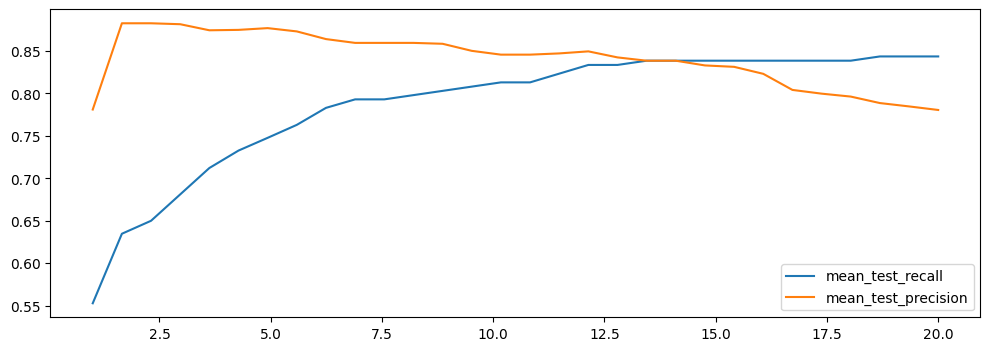

In [18]:
# Plot mean test recall and precision scores for each class weight setting
plt.figure(figsize=(12, 4))
df = pd.DataFrame(grid.cv_results_)
for score in ["mean_test_recall", "mean_test_precision"]:
    plt.plot([_[1] for _ in df["param_class_weight"]], df[score], label=score)
plt.legend()


The first plot shows the test set results:

- The x-axis represents the class weight assigned to fraud cases.
- The y-axis shows the mean test precision and recall scores for each setting.

You can see that increasing the class weight improves recall (detects more fraud) but may reduce precision (more false positives). The optimal balance is often where the two lines intersect, depending on your priorities.

This visualization helps you choose a class weight that aligns with your goals for fraud detection.

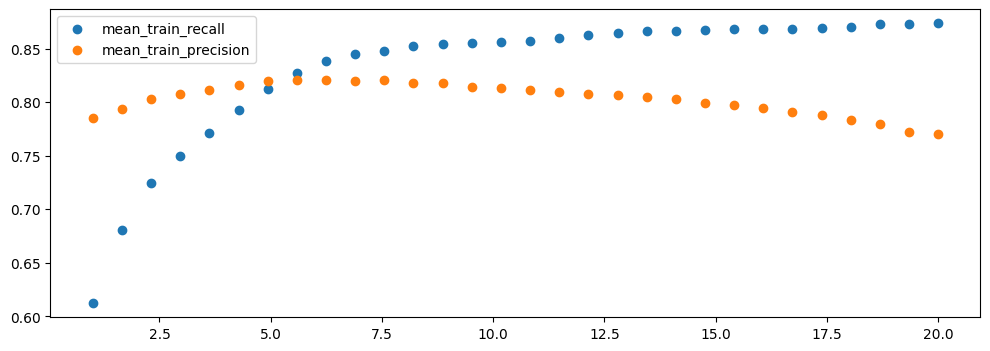

In [19]:
# Plot mean train recall and precision scores for each class weight setting
plt.figure(figsize=(12, 4))
for score in ["mean_train_recall", "mean_train_precision"]:
    plt.scatter(x=[_[1] for _ in df["param_class_weight"]], y=df[score], label=score)
plt.legend()


The second plot shows the training set scores for precision and recall. Comparing train and test scores helps identify overfitting—when a model performs well on training data but poorly on new data.

With two metrics, scikit-learn can optimize for either precision or recall. However, sometimes you want a balance between the two. The **F1 score** is a common metric for this purpose: it is the harmonic mean of precision and recall, providing a single value that balances both.

Alternatively, you can define your own custom metric to reflect your specific needs. For example, you might want to optimize for the minimum of precision and recall to ensure neither is too low. Let's implement such a custom metric next.

## Visual Intuition and Practical Advice

- **Accuracy**: Good when classes are balanced and all errors are equally costly. Not reliable for imbalanced data.
- **Precision**: Use when false positives are costly (e.g., accusing someone of fraud when they are innocent).
- **Recall**: Use when false negatives are costly (e.g., missing a fraud case).
- **F1 Score**: Use when you want a balance between precision and recall, especially for imbalanced datasets.

**Visual Example:**
- Imagine a net catching fish (fraud cases) in a river (all transactions).
  - High recall = big net, catches almost all fish, but may catch some trash (false positives, low precision).
  - High precision = small, selective net, only catches fish, but may miss some (low recall).
  - F1 score = tries to balance both, so you catch most fish and don’t catch too much trash.

**In fraud detection:**
- Usually, recall is very important (don’t miss fraud), but you also want reasonable precision (don’t annoy customers with too many false alarms). F1 score helps you find a good trade-off.

In [ ]:
# Define a custom metric that returns the minimum of recall and precision
def min_recall_precision(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)


Let's add our custom metric, which takes the minimum of precision and recall for each model. This ensures that both metrics are reasonably high, rather than optimizing one at the expense of the other.

We'll call this metric `min_both` and use it in the grid search by passing it to `make_scorer`. We'll also set `refit` to `min_both` so that the best model is selected based on this balanced criterion.

In [21]:
# Add the custom metric to grid search and set refit to select the best model based on this metric
grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1_000),
    param_grid={"class_weight": [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={
        "precision": make_scorer(precision_score),
        "recall": make_scorer(recall_score),
        "min_both": make_scorer(min_recall_precision),  # Add new
    },
    refit="min_both",
    return_train_score=True,
    cv=10,
    n_jobs=-1,
)

grid.fit(X, y)


/Users/hikari/dev/github-ryouze/scikit-learn-practice/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 15.413793103448276},
                                          {0: 1, 1: 16.06896551724138},
                                          {0: 1, 1: 16.724137931034

After running the grid search with the `min_both` metric, we can update our chart to include this new score. The green line represents the minimum of precision and recall for each class weight setting.

The grid search will now select the model where precision and recall are best balanced, according to our custom metric.

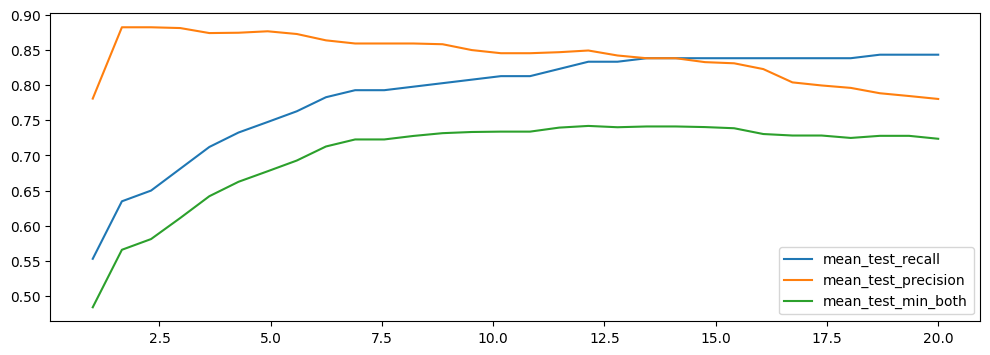

In [22]:
# Plot mean test recall, precision, and min_both scores for each class weight setting
plt.figure(figsize=(12, 4))
df = pd.DataFrame(grid.cv_results_)
for score in ["mean_test_recall", "mean_test_precision", "mean_test_min_both"]:
    plt.plot([_[1] for _ in df["param_class_weight"]], df[score], label=score)
plt.legend();


Notice that the `min_both` (green) line is always at or below the precision and recall lines, since it takes the lower of the two for each setting. This helps ensure that neither metric is neglected when selecting the best model.

Scikit-learn's metric API is flexible: you can use built-in metrics like accuracy, precision, recall, and F1, or define your own to suit your problem. When using custom metrics, you typically wrap them with `make_scorer` so they can be used in grid search and other model selection tools.

Let's take a closer look at how `make_scorer` works and how it adapts your metric function for use in scikit-learn's API.

In [23]:
# Use make_scorer to turn the custom metric into a scorer object for grid search
s = make_scorer(min_recall_precision)
??s


Signature:      s(estimator, X, y_true, sample_weight=None)
Type:           _PredictScorer
String form:    make_scorer(min_recall_precision)
File:           ~/dev/github-ryouze/scikit-learn-practice/env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py
Source:        
class _PredictScorer(_BaseScorer):
    def _score(self, method_caller, estimator, X, y_true, sample_weight=None):
        """Evaluate predicted target values for X relative to y_true.

        Parameters
        ----------
        method_caller : callable
            Returns predictions given an estimator, method name, and other
            arguments, potentially caching results.

        estimator : object
            Trained estimator to use for scoring. Must have a predict_proba
            method; the output of that is used to compute the score.

        X : array-like or sparse matrix
            Test data that will be fed to estimator.predict.

        y_true : array-like
            Gold standard target values

The `make_scorer` function takes a metric function (like our `min_recall_precision`) and turns it into a scorer object that scikit-learn can use in grid search and other model selection tools.

This scorer object accepts an estimator, input data, true labels, and optional sample weights. It allows you to use your custom metric seamlessly within scikit-learn's workflow, without having to rewrite your function to match scikit-learn's expected signature.

Let's demonstrate how to rewrite our custom metric to work directly with scikit-learn's API, without needing `make_scorer`.

In [ ]:
# Rewrite the custom metric to accept an estimator, input data, true labels, and optional sample weights
def min_recall_precision(est, X, y_true, sample_weight=None):
    y_pred = est.predict(X)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)


By updating our custom metric to accept an estimator, input data, true labels, and an optional sample weight, we can use it directly in grid search without `make_scorer`.

The `sample_weight` parameter allows us to give different importance to individual samples, which can be useful in certain applications (e.g., weighting transactions by amount in fraud detection).
Let's see how this works in practice.

In [25]:
# Use the custom metric directly in grid search without make_scorer
grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={"class_weight": [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={
        "precision": make_scorer(precision_score),
        "recall": make_scorer(recall_score),
        "min_both": min_recall_precision,
    },
    refit="min_both",
    return_train_score=True,
    cv=10,
    n_jobs=-1,
)

grid.fit(X, y)


/Users/hikari/dev/github-ryouze/scikit-learn-practice/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hikari/dev/github-ryouze/scikit-learn-practice/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 16.06896551724138},
                                          {0: 1, 1: 16.724137931034484},
                                          {0: 1, 1: 17.379310344827

The `sample_weight` parameter lets you assign more importance to certain samples when evaluating metrics. For example, in fraud detection, you might want to give higher weight to transactions with larger amounts, since catching high-value fraud is especially important.

You can pass sample weights to `grid.fit()` using the `sample_weight` argument. For numerical stability, it's common to use the logarithm of the amount rather than the raw value.

In [ ]:
# # Fit the model using sample weights based on transaction amount
# # grid.fit(X, y, sample_weight=df["Amount"])

# # Use log of amount to prevent overfitting on large transactions
# grid.fit(X, y, sample_weight=np.log(1 + df["Amount"]))


Time: 1:16:41